In [1]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
%load_ext autoreload

In [2]:
logging.debug("test")

2023-12-14 14:51:43,804 - root - DEBUG - test


In [3]:
import pandas as pd
import os
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2023-12-14 14:51:44,336 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-14 14:51:44,337 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-12-14 14:51:44,744 - matplotlib - DEBUG - matplotlib data path: /cmnfs/home/z.xiao/.local/lib/python3.10/site-packages/matplotlib/mpl-data
2023-12-14 14:51:44,772 - matplotlib - DEBUG - CONFIGDIR=/cmnfs/home/z.xiao/.config/matplotlib
2023-12-14 14:51:44,774 - matplotlib - DEBUG - interactive is False
2023-12-14 14:51:44,775 - matplotlib - DEBUG - platform is linux
2023-12-14 14:51:44,847 - matplotlib - DEBUG - CACHEDIR=/cmnfs/home/z.xiao/.cache/matplotlib
2023-12-14 14:51:44,866 - matplotlib.font_manager - DEBUG - Using fontManager instance from /cmnfs/home/z.xiao/.cache/matplotlib/fontlist-v330.json


# Load Data

In [4]:
# path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
maxquant_file_dict = (
    "/cmnfs/proj/ORIGINS/data/ecoli/HpHRP/MQ/1FDR/"
    "combined/txt/evidence_1_FilteredByClosestRT_transfer_RT_pred_filtered_withIso.pkl"
)
maxquant_file_exp = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/MQ/combined/txt/evidence_1.txt"
)

MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
# experiment specific
result_dir = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_MZtol0.0_condpeakRange_alpha0.0_threshold_abthres0.001_missabthres0.5_convergence_NoIntercept_mix"
)
basename = os.path.basename(result_dir)
output_file = os.path.join(result_dir, basename + "_output")  # filename

In [5]:
Maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_dict)
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width3_None_Retention_time_new.csv")
)
peak_results.matched.describe()

count     160178
unique         2
top        False
freq      108483
Name: matched, dtype: object

In [6]:
# SBS windows
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_path)
MS1Scans_NoArray["scan_number"] = MS1Scans_NoArray.index.astype(int)
RT_ref = "predicted_RT"
RT_tol = 1
sbs_windows = Maxquant_result_dict[["id", RT_ref]]
sbs_windows["sbs_window_left"] = sbs_windows[RT_ref] - RT_tol
sbs_windows["sbs_window_right"] = sbs_windows[RT_ref] + RT_tol
sbs_windows.sort_values(by="sbs_window_left", inplace=True)
sbs_windows = pd.merge_asof(
    sbs_windows,
    MS1Scans_NoArray[["starttime", "scan_number"]],
    left_on="sbs_window_left",
    right_on="starttime",
    direction="nearest",
)
sbs_windows = pd.merge_asof(
    sbs_windows,
    MS1Scans_NoArray[["starttime", "scan_number"]],
    left_on="sbs_window_right",
    right_on="starttime",
    direction="nearest",
    suffixes=["_left", "_right"],
)
sbs_windows["starttime_length"] = (
    sbs_windows["starttime_right"] - sbs_windows["starttime_left"]
)
sbs_windows["scan_number_length"] = (
    sbs_windows["scan_number_right"] - sbs_windows["scan_number_left"]
)

/tmp/ipykernel_2722742/2406514058.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs_windows["sbs_window_left"] = sbs_windows[RT_ref] - RT_tol
/tmp/ipykernel_2722742/2406514058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sbs_windows["sbs_window_right"] = sbs_windows[RT_ref] + RT_tol
/tmp/ipykernel_2722742/2406514058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [7]:
sbs_windows["scan_number_length"].describe()
sbs_windows["starttime_length"].describe()
peak_results = pd.merge(
    left=peak_results, right=sbs_windows, on="id", how="left")

count    63013.000000
mean       119.168251
std         19.503501
min        116.000000
25%        116.000000
50%        117.000000
75%        117.000000
max        390.000000
Name: scan_number_length, dtype: float64

count    63013.000000
mean         1.999964
std          0.008106
min          1.736767
25%          1.991852
50%          2.003904
75%          2.006835
max          2.016720
Name: starttime_length, dtype: float64

# Exploring finding peaks algo

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks

x = electrocardiogram()[2000:4000]

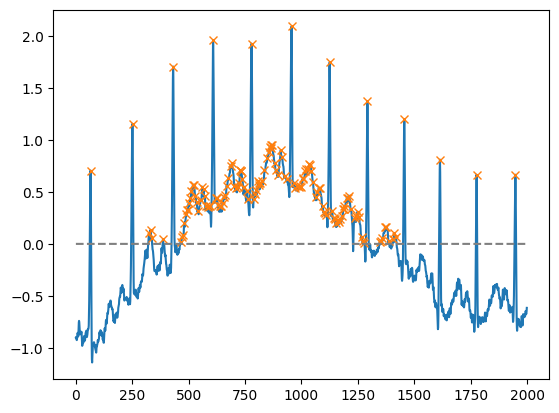

In [37]:
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

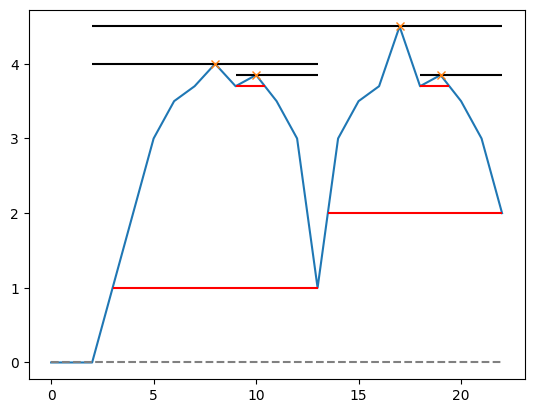

In [38]:
# Limit distance
x = np.array(
    [
        0,
        0,
        0,
        1,
        2,
        3,
        3.5,
        3.7,
        4,
        3.7,
        3.85,
        3.5,
        3,
        1,
        3,
        3.5,
        3.7,
        4.5,
        3.7,
        3.85,
        3.5,
        3,
        2,
    ]
)
peaks, properties = find_peaks(
    x, prominence=0, width=0, height=0, rel_height=1)
plt.plot(x)
for idx, peak in enumerate(peaks):
    # print(idx, peak)
    plt.hlines(
        xmin=properties["left_ips"][idx],
        xmax=properties["right_ips"][idx],
        y=properties["width_heights"][idx],
        color="red",
    )
    plt.hlines(
        xmin=properties["left_bases"][idx],
        xmax=properties["right_bases"][idx],
        y=properties["peak_heights"][idx],
        color="black",
    )
    # plt.hlines(
    #     xmin=peak - 0.5 * properties["widths"][idx],
    #     xmax=peak + 0.5 * properties["widths"][idx],
    #     y=properties["peak_heights"][idx],
    #     color="green",
    # )
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [39]:
properties

{'peak_heights': array([4.  , 3.85, 4.5 , 3.85]),
 'prominences': array([3.  , 0.15, 2.5 , 0.15]),
 'left_bases': array([ 2,  9,  2, 18]),
 'right_bases': array([13, 13, 22, 22]),
 'widths': array([10.        ,  1.42857143,  8.5       ,  1.42857143]),
 'width_heights': array([1. , 3.7, 2. , 3.7]),
 'left_ips': array([ 3. ,  9. , 13.5, 18. ]),
 'right_ips': array([13.        , 10.42857143, 22.        , 19.42857143])}

# Extract Activation Peak
see extract_peak.py

# Peak extraction with different width

Number of precursors: 55753
Label distribution:
False    208013
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  263766.000000  2.637660e+05        2.637660e+05  2.637660e+05  263766.000000  263766.000000  263766.000000
mean   100514.209747    1129.355470      14.737834    1127.000057      14.699651    1132.004455      14.780400       5.004398  3.133223e+07        2.018463e+06  4.677740e-01       0.566401       0.558739       1.125140
std     58028.936860     530.692603       8.916898     530.754764       8.914841     530.598154       8.919384       5.981154  1.427096e+08        1.025395e+07  3.053284e-01       0.711914       0.715395       1.406701
min         0.000000      

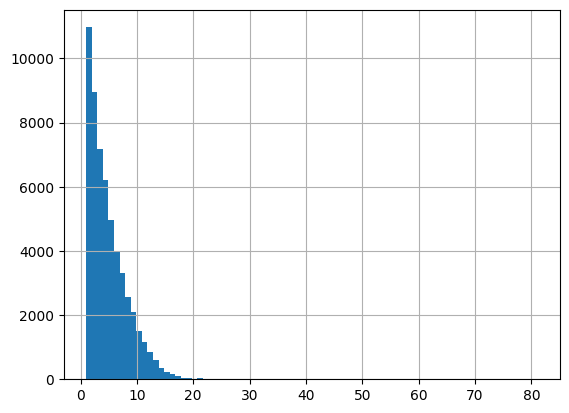

In [45]:
# Width = 1
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width1_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 55753
Label distribution:
False    202908
True      55753
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  258661.000000  2.586610e+05        2.586610e+05  2.586610e+05  258661.000000  258661.000000  258661.000000
mean   100500.713942    1133.850623      14.807237    1131.461778      14.768472    1136.540514      14.850498       5.078736  3.180421e+07        2.053892e+06  4.675197e-01       0.566178       0.559251       1.125429
std     58042.986541     528.198222       8.886482     528.276702       8.884657     528.084525       8.888722       6.015908  1.440531e+08        1.035122e+07  3.055485e-01       0.712962       0.716464       1.409157
min         0.000000      

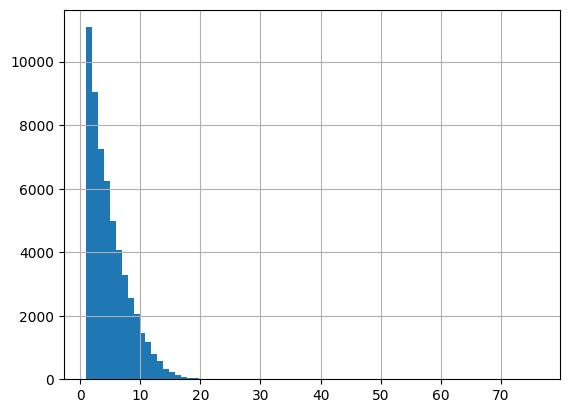

In [46]:
# Width = 2
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width2_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

Number of precursors: 51695
Label distribution:
False    108483
True      51695
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  160178.000000  1.601780e+05        1.601780e+05  1.601780e+05  160178.000000  160178.000000  160178.000000
mean   100302.708506    1142.212345      14.944811    1138.975365      14.892283    1145.935878      15.004608       6.960513  4.785421e+07        3.240916e+06  4.487215e-01       0.540794       0.536162       1.076956
std     58034.473869     527.948288       8.896179     528.104628       8.894360     527.722967       8.898489       7.009378  1.797651e+08        1.300499e+07  3.143144e-01       0.714881       0.718058       1.415272
min         0.000000      

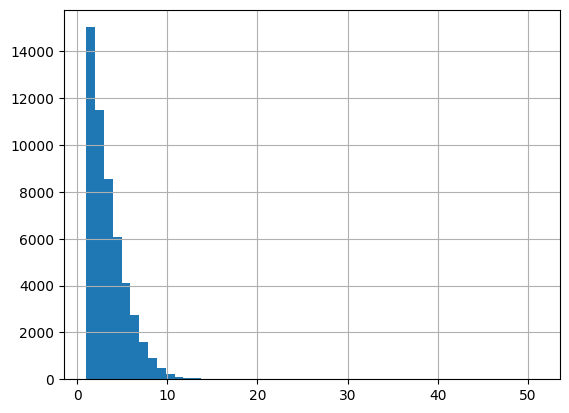

In [66]:
# Width = 3
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width3_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

3.971890897899969

array([[<Axes: title={'center': 'RT_diff_sum'}>]], dtype=object)

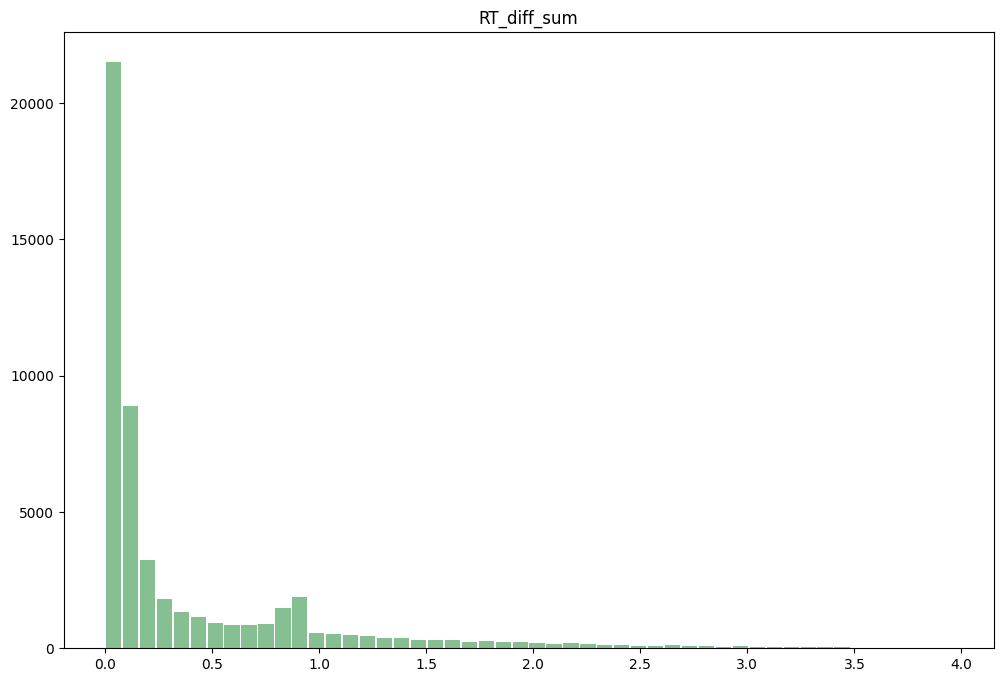

In [61]:
peak_results["RT_diff_sum"].quantile(0.99)
peak_results.loc[
    (peak_results.matched == 1) & (peak_results["RT_diff_sum"] <= 3.97)
].hist(
    column="RT_diff_sum",
    bins=50,
    grid=False,
    figsize=(12, 8),
    color="#86bf91",
    zorder=2,
    rwidth=0.9,
)

Number of precursors: 49362
Label distribution:
False    78326
True     49362
All peak results:
                  id      apex_scan      apex_time     start_scan     start_time       end_scan       end_time     peak_width   peak_height  peak_intensity_auc  RT_apex_diff  RT_start_diff    RT_end_diff    RT_diff_sum
count  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  127688.000000  1.276880e+05        1.276880e+05  1.276880e+05  127688.000000  127688.000000  127688.000000
mean   100288.001418    1149.007025      15.051743    1145.332960      14.992082    1153.290442      15.120507       7.957482  5.778511e+07        3.993390e+06  4.340126e-01       0.523953       0.519493       1.043446
std     58051.711698     519.486899       8.766350     519.710087       8.764903     519.165352       8.768269       7.531420  1.994352e+08        1.446028e+07  3.169667e-01       0.709495       0.712316       1.405587
min         0.000000      37

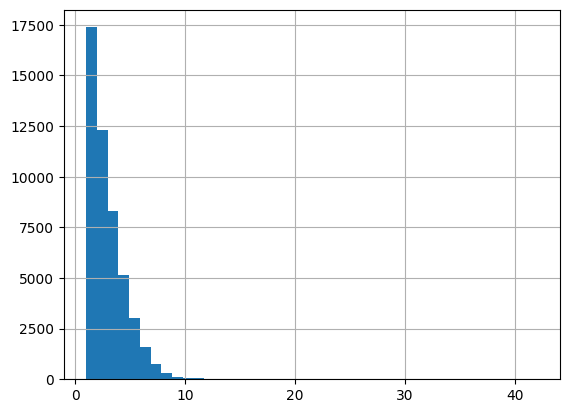

In [48]:
# Width = 4
peak_results = pd.read_csv(
    os.path.join(result_dir, "peak_results_width4_None_Retention_time_new.csv")
)
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results,
    initial_bias="auto",
)
mdl.report_data_distribution()

# Train peak selection CNN model

peak_results mark the annotated data:
- matched: binary classification task


In [8]:
refit_activation_minima = np.load(output_file + "_activationMinima.npy")
refit_activation_minima_df = pd.DataFrame(refit_activation_minima).set_index(
    Maxquant_result_dict.index
)
refit_activation_minima_df.columns = refit_activation_minima_df.columns

In [9]:
peak_results_filtered = (
    peak_results.groupby("id").filter(lambda x: len(x) > 1).reset_index()
)
selected_id = peak_results_filtered.loc[
    (peak_results_filtered.matched == 1) & (peak_results_filtered.RT_diff_sum <= 1)
].id.unique()
# peak_results_filtered = peak_results_filtered.loc[
#     peak_results_filtered.id.isin(selected_id)
# ].reset_index()

In [63]:
%autoreload 2
from postprocessing.peak_selection import prepare_peak_input
peak_arrays = prepare_peak_input(peak_results_filtered, 
                                refit_activation_minima_df,
                                log_intensity=False, 
                                standardize="minmax", 
                                method= 'mask')

In [68]:
%autoreload 2
from postprocessing.peak_selection import PeakSelectionModel
config = {
    "model": "CNN",
    "conv1_n_filters": 16,
    "conv1_kernel_size": 3,
    "conv2_n_filters": 32,
    "conv2_kernel_size": 3,
    "n_epochs": 100,
    "dense1_n": 64,
    "dense1_reg_rate": 0.001,
    "dropout_rate": 0.5,
    "learning_rate": 0.0001,
}
mdl = PeakSelectionModel(
    peak_input=peak_arrays,
    peak_results=peak_results_filtered.iloc[0:10000, :],
    initial_bias="auto",
    use_class_weight=True,
)
mdl.pad_peak_input(padding="two_side", value=0.0)
mdl.split_data(by_precrusor=True, normalize=False)
# mdl.resample_train_data(resample_method="oversample")

mdl.make_model(config=config)
mdl.train_model(epochs=100, weight_class=False)

2023-12-14 15:57:30,427 - numba.core.byteflow - DEBUG - bytecode dump:
>          0	NOP(arg=None, lineno=186)
           2	LOAD_GLOBAL(arg=0, lineno=188)
           4	LOAD_METHOD(arg=1, lineno=188)
           6	LOAD_FAST(arg=1, lineno=188)
           8	BUILD_TUPLE(arg=1, lineno=188)
          10	LOAD_FAST(arg=2, lineno=188)
          12	CALL_METHOD(arg=2, lineno=188)
          14	STORE_FAST(arg=3, lineno=188)
          16	LOAD_FAST(arg=1, lineno=189)
          18	LOAD_GLOBAL(arg=2, lineno=189)
          20	LOAD_FAST(arg=0, lineno=189)
          22	CALL_FUNCTION(arg=1, lineno=189)
          24	BINARY_SUBTRACT(arg=None, lineno=189)
          26	STORE_FAST(arg=4, lineno=189)
          28	LOAD_FAST(arg=4, lineno=190)
          30	LOAD_CONST(arg=1, lineno=190)
          32	BINARY_FLOOR_DIVIDE(arg=None, lineno=190)
          34	STORE_FAST(arg=5, lineno=190)
          36	LOAD_FAST(arg=0, lineno=192)
          38	LOAD_FAST(arg=3, lineno=192)
          40	LOAD_FAST(arg=5, lineno=192)
          

Examples:
    Total: 8003
    Positive: 1973 (24.65% of total)

Epoch 1/100
251/251 [==============================] - 4s 11ms/step - loss: 0.8088 - cross entropy: 0.5518 - Brier score: 0.1829 - tp: 9.0000 - fp: 8.0000 - tn: 6022.0000 - fn: 1964.0000 - accuracy: 0.7536 - precision: 0.5294 - recall: 0.0046 - auc: 0.6141 - prc: 0.3412 - val_loss: 0.5981 - val_cross entropy: 0.5612 - val_Brier score: 0.1868 - val_tp: 0.0000e+00 - val_fp: 1.0000 - val_tn: 1502.0000 - val_fn: 494.0000 - val_accuracy: 0.7521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6825 - val_prc: 0.3569
Epoch 2/100
251/251 [==============================] - 2s 8ms/step - loss: 0.7058 - cross entropy: 0.6066 - Brier score: 0.2079 - tp: 743.0000 - fp: 1187.0000 - tn: 4843.0000 - fn: 1230.0000 - accuracy: 0.6980 - precision: 0.3850 - recall: 0.3766 - auc: 0.6535 - prc: 0.3524 - val_loss: 0.6564 - val_cross entropy: 0.6239 - val_Brier score: 0.2163 - val_tp: 276.0000 - val_fp: 421.0000 - val_tn: 1082.00

In [69]:
mdl.evaluate_id_based_cls(top_n=1)
mdl.evaluate_id_based_cls(top_n=2)
mdl.evaluate_id_based_cls(top_n=3)
mdl.evaluate_id_based_cls(top_n=4)
mdl.evaluate_id_based_cls(top_n=5)
mdl.evaluate_id_based_cls(top_n=6)

63/63 [==============================] - 0s 2ms/step


0.47368421052631576

63/63 [==============================] - 0s 2ms/step


0.7813765182186235

63/63 [==============================] - 0s 2ms/step


0.8846153846153846

63/63 [==============================] - 0s 2ms/step


0.9433198380566802

63/63 [==============================] - 0s 2ms/step


0.979757085020243

63/63 [==============================] - 0s 2ms/step


0.9858299595141701

<Axes: xlabel='y_pred_prob', ylabel='Density'>

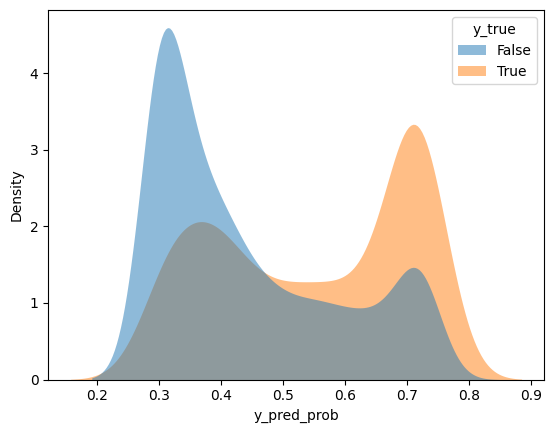

In [70]:
import seaborn as sns

test_df = mdl.df_test
sns.kdeplot(
    data=test_df,
    x="y_pred_prob",
    hue="y_true",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

251/251 [==============================] - 1s 3ms/step


<Axes: xlabel='y_pred_prob', ylabel='Density'>

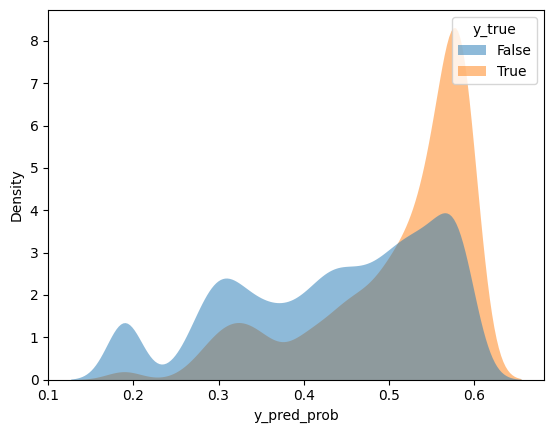

In [52]:
y_train_pred_prob = mdl.class_model.predict(mdl.X_train)
train_df = pd.DataFrame(
    {
        "precursor_id": mdl.precursor_id[mdl.train_indices],
        "y_pred_prob": y_train_pred_prob.flatten(),
        "y_true": mdl.y_train,
    }
)
sns.kdeplot(
    data=train_df,
    x="y_pred_prob",
    hue="y_true",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
)

<Figure size 1000x600 with 0 Axes>

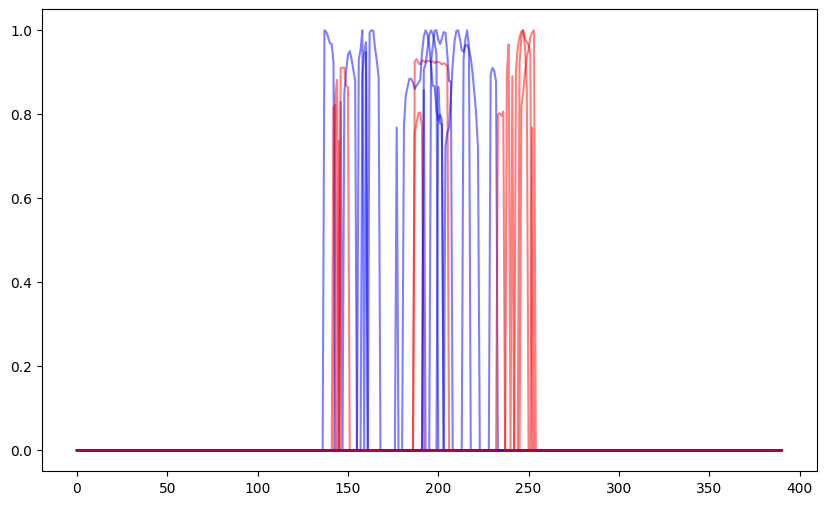

In [67]:
# Define the number of samples to select
num_samples = 10

# Randomly select samples from each group
indices_train_true = np.random.choice(
    X_train_true.shape[0], num_samples, replace=False)
indices_train_false = np.random.choice(
    X_train_false.shape[0], num_samples, replace=False
)

indices_test_true = np.random.choice(
    X_test_true.shape[0], num_samples, replace=False)
indices_test_false = np.random.choice(
    X_test_false.shape[0], num_samples, replace=False)

# Use the selected indices to get the samples
X_train_true_sampled = X_train_true[indices_train_true]
X_train_false_sampled = X_train_false[indices_train_false]

X_test_true_sampled = X_test_true[indices_test_true]
X_test_false_sampled = X_test_false[indices_test_false]

# Plot the sampled data
plt.figure(figsize=(10, 6))

for i in range(num_samples):
    plt.plot(X_train_true_sampled[i, :, 0], color="b", alpha=0.5)
    plt.plot(X_train_false_sampled[i, :, 0], color="r", alpha=0.5)
    # plt.plot(X_test_true_sampled[i, :, 0], color="g", alpha=0.5)
    # plt.plot(X_test_false_sampled[i, :, 0], color="y", alpha=0.5)

plt.show()